In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat
import time

default_dtype = torch.float64 #https://pytorch.org/docs/stable/generated/torch.set_default_dtype.html
torch.set_default_dtype(default_dtype)


In [ ]:
#Make gradient ? not sure why this works
#theowolf code https://github.com/TheodoreWolf/pinns/blob/main/src/cooling/temp_pred.ipynb

import matplotlib.pyplot as plt

def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)


#Make an NN
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class YWTry(torch.nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        N=100,
        epochs=1000,
        viscosity=False,
        mu=0.00,
        #loss=nn.MSELoss(),
        lr=1e-4,
        #loss2=None,
        loss2_weight=0.1,
    ): #-> None:
        super().__init__()

        self.epochs = epochs
        #self.loss = loss
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.mu=mu
        self.viscosity=viscosity
        self.N=N

        self.layers = nn.Sequential(
            nn.Linear(input_dim, 20), #the linear transform part https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
            nn.Tanh(), #the activation func I changed to tanh
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
        )
        self.out = nn.Linear(20, output_dim) #the final transform

    def forward(self, x):
        h = self.layers(x) #it gives you the input as transformed by the hidden layers of the neural networks
        out = self.out(h) #prints out the final product. 'out' as tensor
        return out


    def Train(self, X, y):
        #import random

        start=time.time()
        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train() #https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch

       def loss_f(input):
          U=self.Model(input)[:,0]
          a=grad(U,input)[0]
          Ux=a[:,0]
          Ut=a[:,1]
          return ((Ut+U*Ux)**2).mean()

        # inputinit = torch.column_stack((torch.tensor([random.random() for i in range(self.N)]), torch.zeros(N)))
        # k=torch.hstack((torch.zeros(self.N), torch.ones(self.N)))
        # inputboundary = torch.column_stack((k, torch.tensor([random.random() for i in range(2*self.N)])))
        # outputinit=torch.sin(np.pi*inputinit[:,0])
        # outputboundary= torch.zeros(2*self.N)
        # inputs =torch.cat((inputinit, inputboundary))
        # Outputs=torch.cat((outputinit, outputboundary))

        def loss_g(inputs, outputs):
          loss=(inputs-outputs)**2
          return loss.mean()

        def loss_f(input):
          U=self.Model(input)[:,0] #Siyong fix: make it an N vector
          a=grad(U,input)[0] #because it returns you a tuple
          Ux=a[:,0]
          Ut=a[:,1] #already an N vector
          #Uxx=grad(Ux,input[0])
          return ((Ut+U*Ux)**2).mean()

        def loss_fv(input):
          U=self.Model(input)[:,0]
          a=grad(U,input)[0]
          Ux=a[:,0]
          Ut=a[:,1]
          Uxx=grad(Ux,input[0])
          return ((Ut+U*Ux-self.mu*Uxx)**2).mean()

          if self.viscosity==True:
            loss_f=loss_fv
          else:
            pass



        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(X)
            loss = loss_g(y, outputs[:,0]) + loss_f(cpts)
            loss.backward()
            optimiser.step()
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss_g: {loss_g(y, outputs[:,0]).item():.2f}, loss_f: {loss_f(cpts).item():.2f}")
                print('time elapsed: {}'.format(time.time()-start))
                t=np.linspace(0,1,11)
                for tm in t:
                  xn=np.linspace(0,1,1000)
                  x=torch.tensor(xn, dtype=default_dtype)
                  coord=torch.column_stack((x,torch.full(x.shape, tm))) #https://pytorch.org/docs/stable/generated/torch.full.html
                  Uout=samplemodel.Model(coord).detach().numpy()
                  plt.plot(xn,Uout, label='t={}'.format(tm))
                  plt.legend()
                plt.show()
        return ()

    def Model(self, X):
        self.eval()
        out = self.forward(X)
        return out #.detach().cpu().numpy()



In [ ]:
#test data
N=100
import random

#initial condition, t=0
inputinit = torch.column_stack((torch.tensor([random.random() for i in range(N)]), torch.zeros(N)))
print(inputinit.shape)

#boundary condition, x=0, x=1, t is random in [0,1]
k=torch.hstack((torch.zeros(N), torch.ones(N)))
inputboundary = torch.column_stack((k, torch.tensor([random.random() for i in range(2*N)])))

#output for initial condition
outputinit=torch.sin(np.pi*inputinit[:,0])
print(outputinit.shape)
#print(outputinit)
#output for no-penetrations conditions on boundary:
outputboundary= torch.zeros(2*N)
#print(outputboundary.shape)

#collocation pts to check physics loss
cpts = torch.column_stack((torch.tensor([random.random() for i in range(2*N)], requires_grad=True), torch.tensor([random.random() for i in range(2*N)], requires_grad=True)))


#print(cpts)
#print(cpts[3])
print(type(cpts[3]))
#Stick together (concatenate: along the same dim)
inputs =torch.cat((inputinit, inputboundary))
Outputs=torch.cat((outputinit, outputboundary))

#print(inputs, outputs)


torch.Size([100, 2])
torch.Size([100])
<class 'torch.Tensor'>


Epoch 0/30000, loss_g: 0.13, loss_f: 0.00
time elapsed: 2.8942835330963135


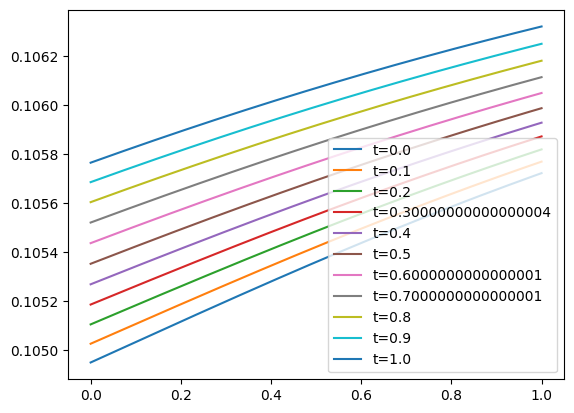

Epoch 3000/30000, loss_g: 0.04, loss_f: 0.01
time elapsed: 28.924254179000854


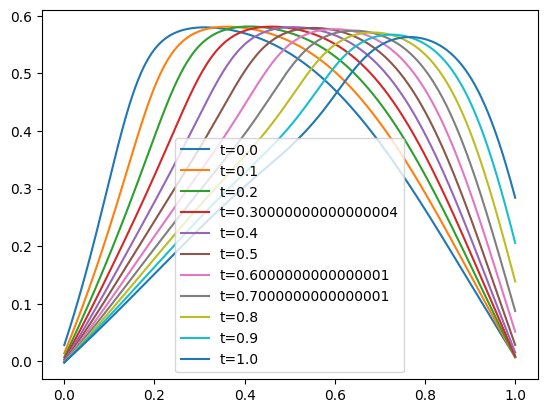

Epoch 6000/30000, loss_g: 0.03, loss_f: 0.01
time elapsed: 55.24361753463745


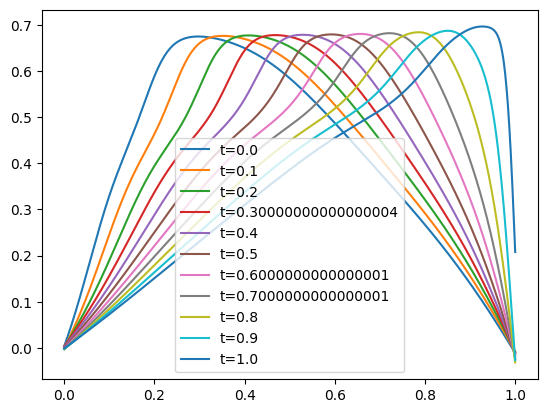

Epoch 9000/30000, loss_g: 0.01, loss_f: 0.00
time elapsed: 81.38491940498352


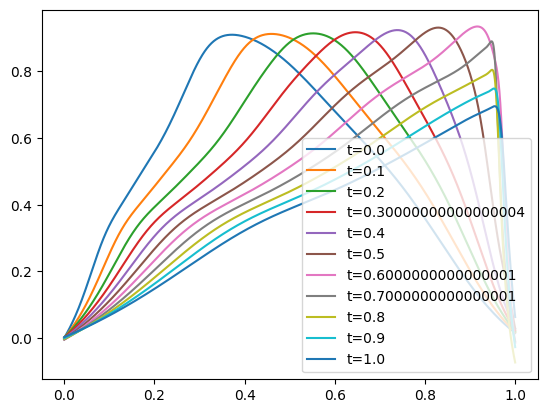

Epoch 12000/30000, loss_g: 0.00, loss_f: 0.00
time elapsed: 109.09728956222534


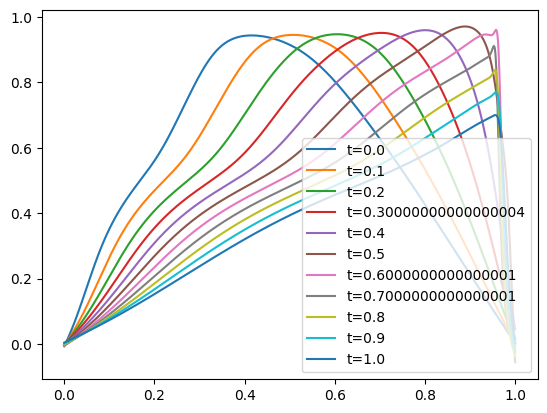

Epoch 15000/30000, loss_g: 0.00, loss_f: 0.00
time elapsed: 135.2606635093689


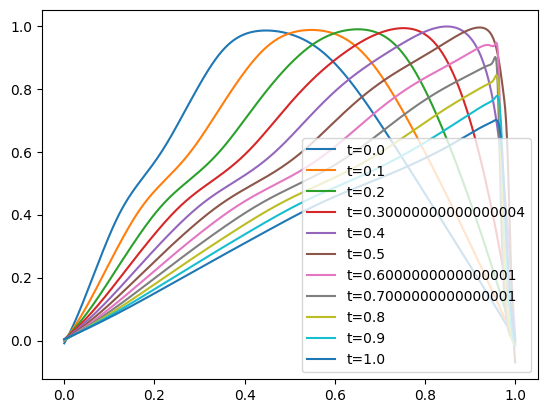

Epoch 18000/30000, loss_g: 0.01, loss_f: 0.01
time elapsed: 162.22858786582947


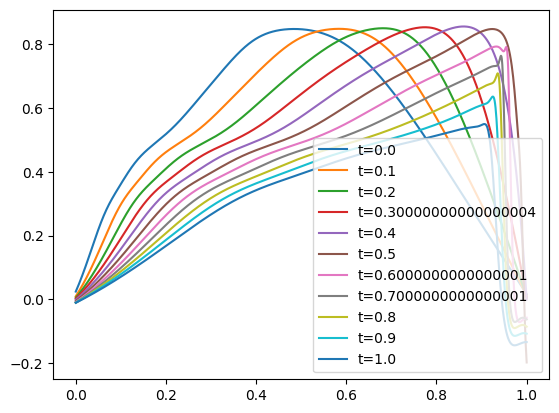

Epoch 21000/30000, loss_g: 0.03, loss_f: 0.04
time elapsed: 188.56697726249695


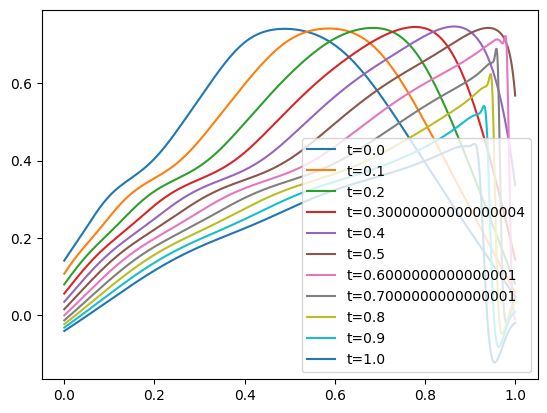

Epoch 24000/30000, loss_g: 0.01, loss_f: 0.00
time elapsed: 214.76627659797668


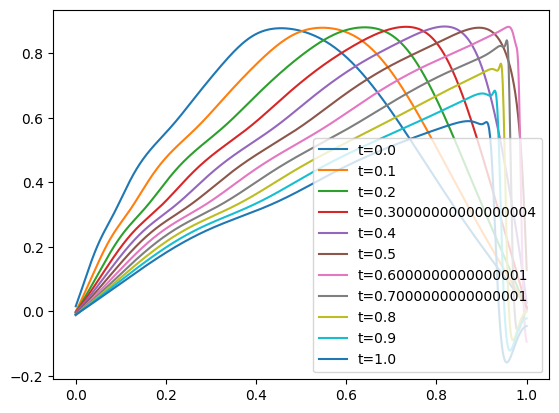

Epoch 27000/30000, loss_g: 0.00, loss_f: 0.00
time elapsed: 242.07712531089783


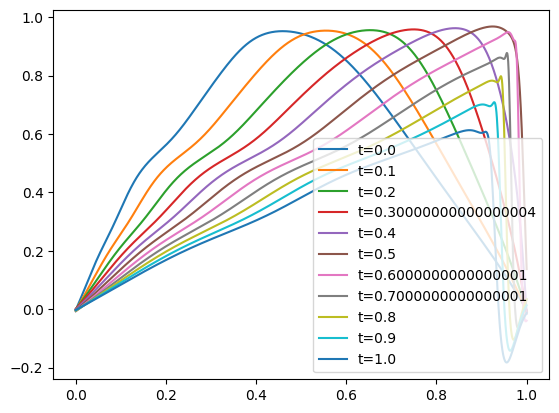

()

In [ ]:
samplemodel=YWTry(2,1, epochs=30000, lr=5e-5).to(DEVICE)
samplemodel.Train(inputs, Outputs)

Epoch 0/30000, loss: 0.21
time elapsed: 2.259427785873413


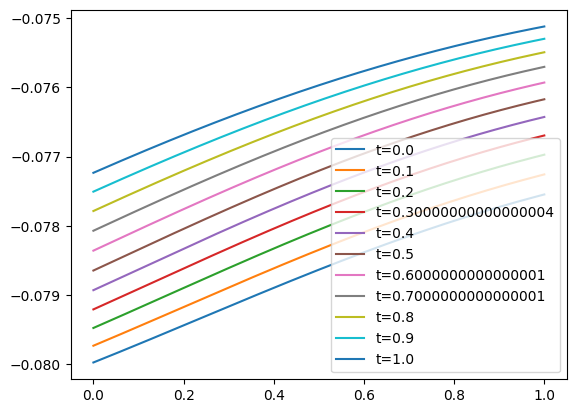

Epoch 3000/30000, loss: 0.06
time elapsed: 29.555081844329834


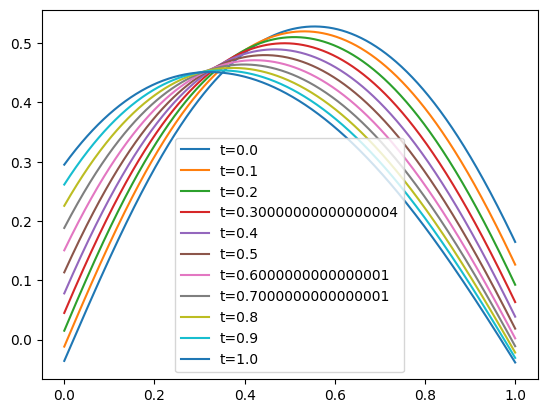

Epoch 6000/30000, loss: 0.05
time elapsed: 58.14758038520813


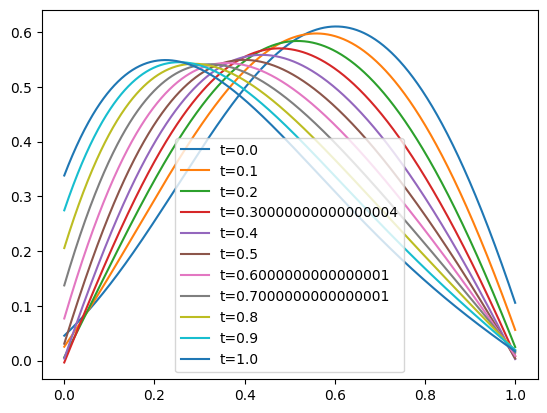

Epoch 9000/30000, loss: 0.05
time elapsed: 91.60554599761963


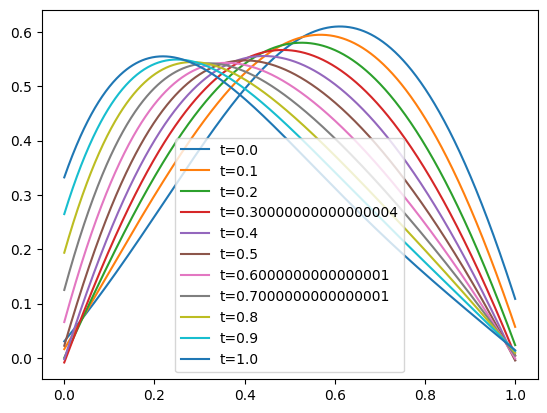

Epoch 12000/30000, loss: 0.04
time elapsed: 124.12467432022095


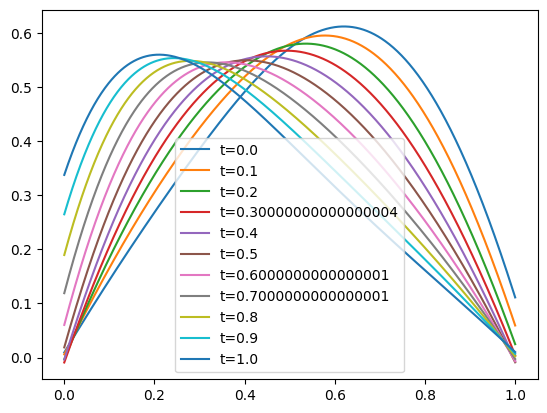

Epoch 15000/30000, loss: 0.04
time elapsed: 151.3143994808197


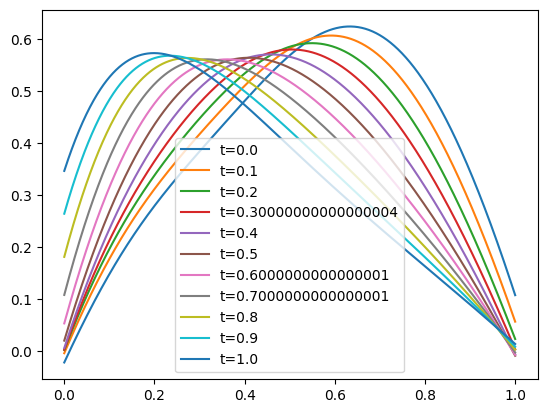

Epoch 18000/30000, loss: 0.04
time elapsed: 178.84424591064453


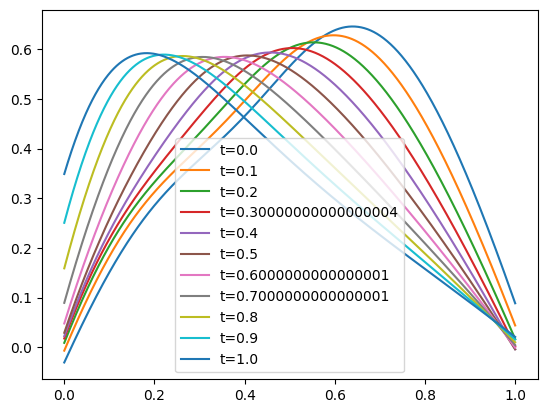

Epoch 21000/30000, loss: 0.04
time elapsed: 208.3599193096161


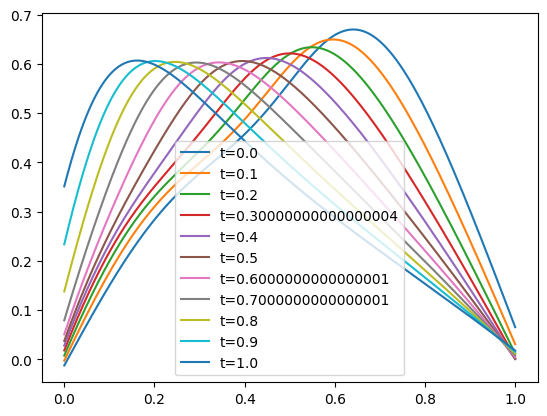

Epoch 24000/30000, loss: 0.04
time elapsed: 235.61738276481628


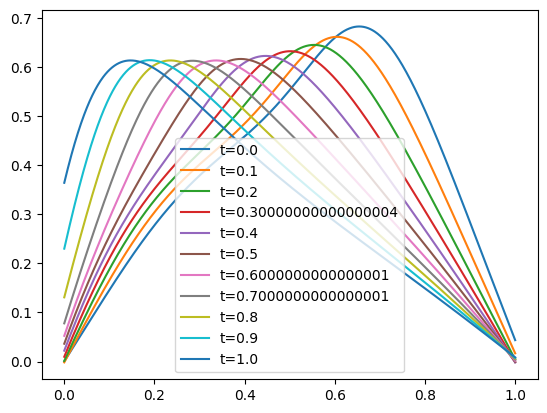

Epoch 27000/30000, loss: 0.04
time elapsed: 263.144410610199


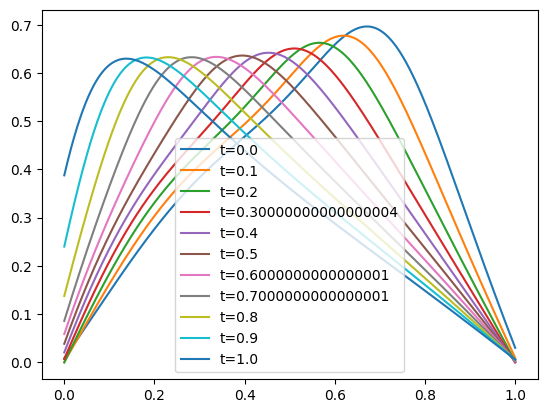

()

In [ ]:
#Results
samplemodel=YWTry(2,1, epochs=30000, lr=5e-5).to(DEVICE)
samplemodel.Train(inputs, Outputs)

Epoch 0/30000, loss: 0.24
time elapsed: 0.023215055465698242


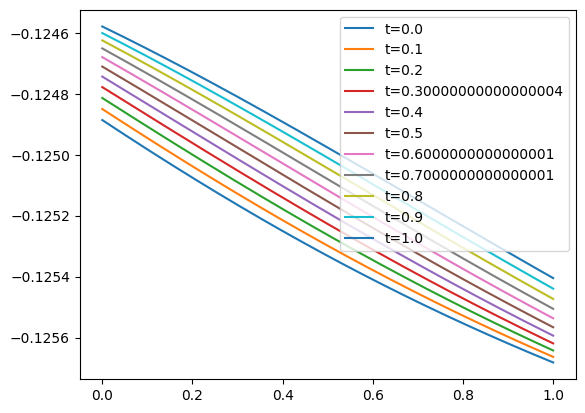

Epoch 3000/30000, loss: 0.06
time elapsed: 29.463794708251953


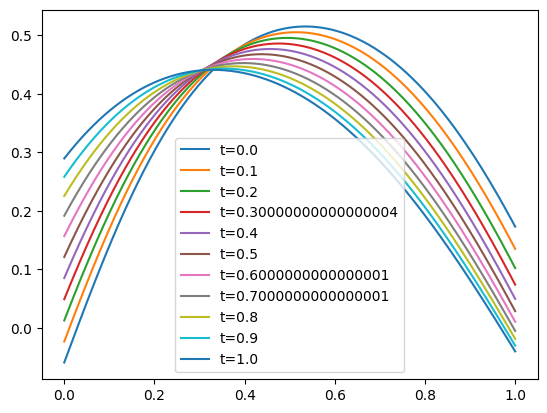

Epoch 6000/30000, loss: 0.04
time elapsed: 56.90430164337158


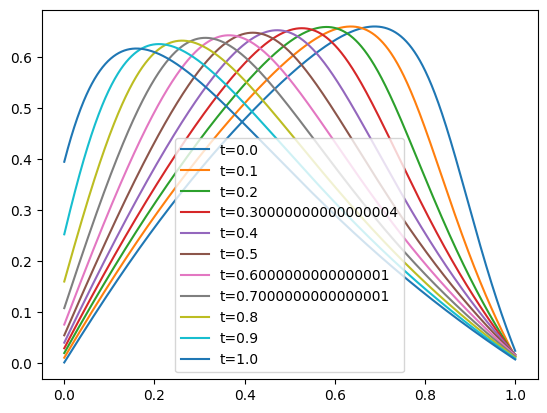

Epoch 9000/30000, loss: 0.03
time elapsed: 84.3065197467804


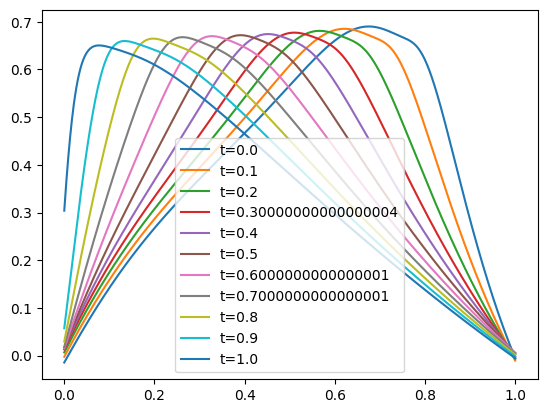

Epoch 12000/30000, loss: 0.03
time elapsed: 111.74856376647949


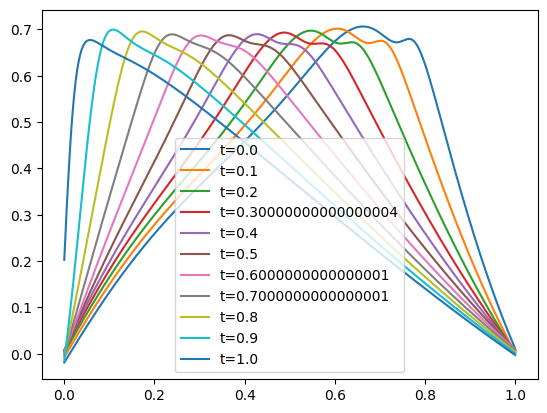

Epoch 15000/30000, loss: 0.03
time elapsed: 139.85070633888245


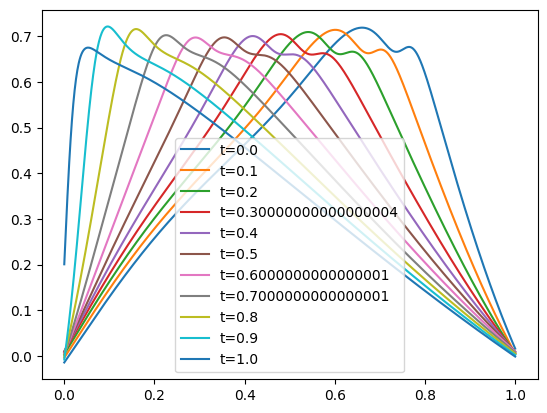

Epoch 18000/30000, loss: 0.03
time elapsed: 168.62026286125183


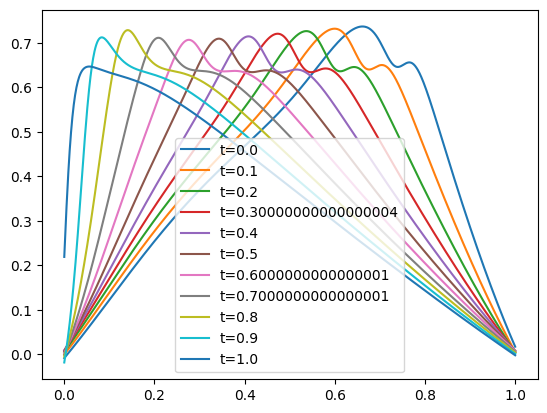

Epoch 21000/30000, loss: 0.03
time elapsed: 196.15882468223572


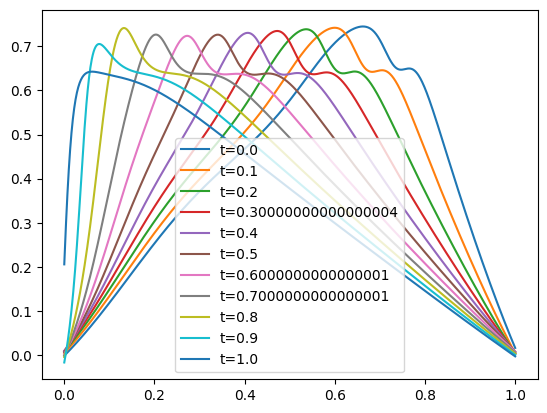

Epoch 24000/30000, loss: 0.03
time elapsed: 223.57181453704834


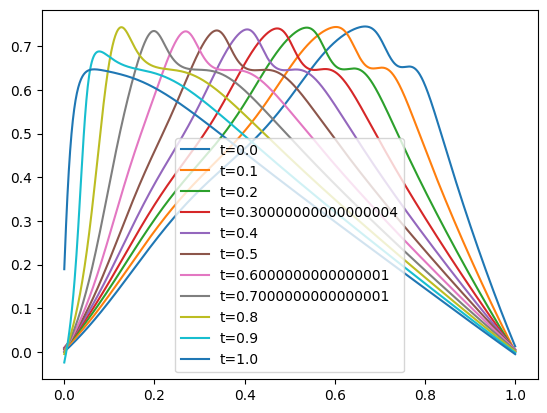

Epoch 27000/30000, loss: 0.03
time elapsed: 250.77021837234497


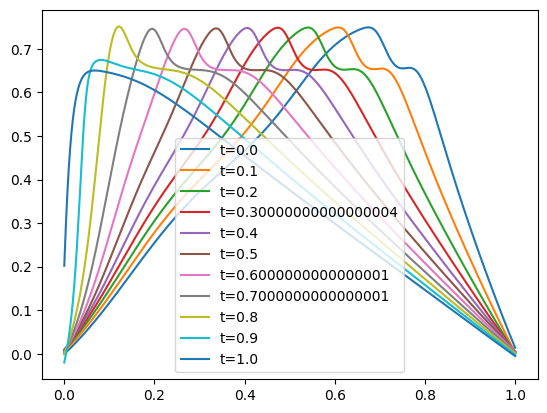

()

In [ ]:
samplemodel.Train(inputs, Outputs) #sample bdry conditon and colocation pts as previous. But I added the viscosity feature to the model

Epoch 0/30000, loss: 0.26
time elapsed: 0.017869949340820312


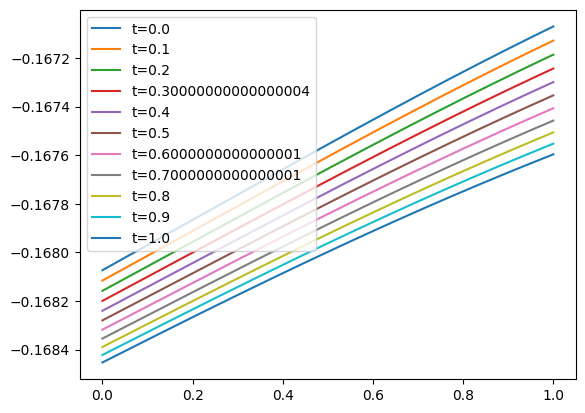

Epoch 3000/30000, loss: 0.03
time elapsed: 29.02367925643921


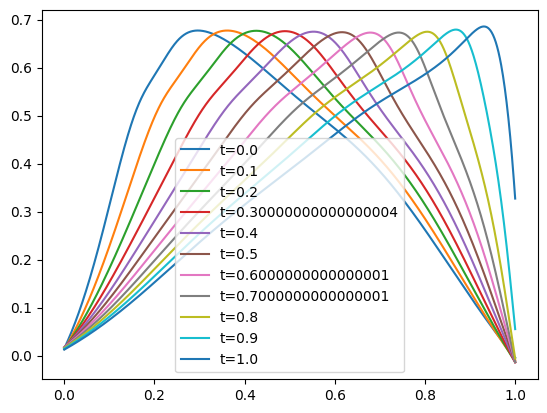

Epoch 6000/30000, loss: 0.03
time elapsed: 57.236079454422


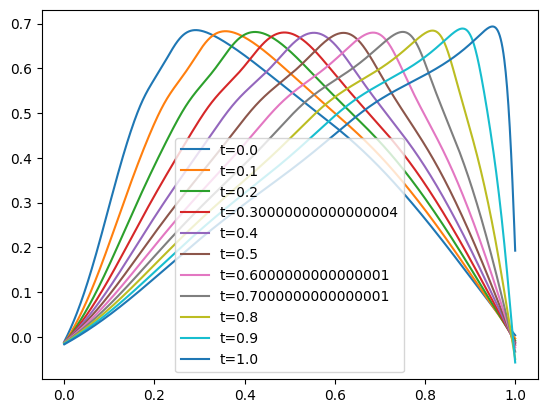

Epoch 9000/30000, loss: 0.03
time elapsed: 87.16938257217407


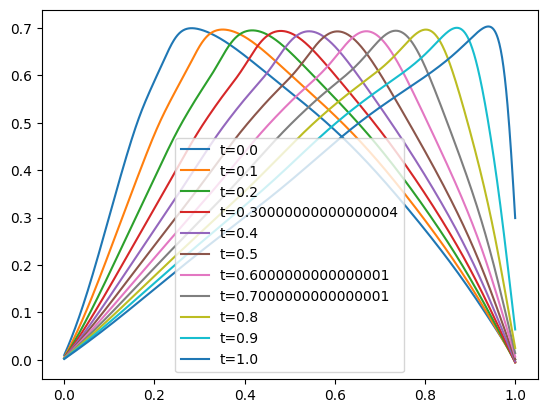

Epoch 12000/30000, loss: 0.03
time elapsed: 117.81253862380981


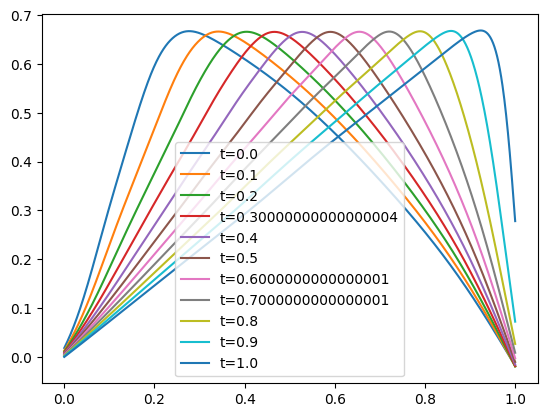

Epoch 15000/30000, loss: 0.03
time elapsed: 147.4608120918274


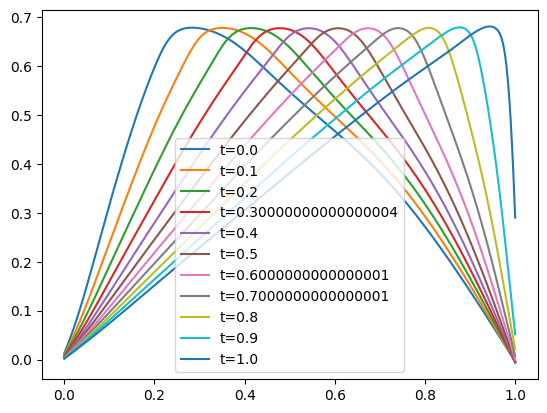

Epoch 18000/30000, loss: 0.05
time elapsed: 177.3022723197937


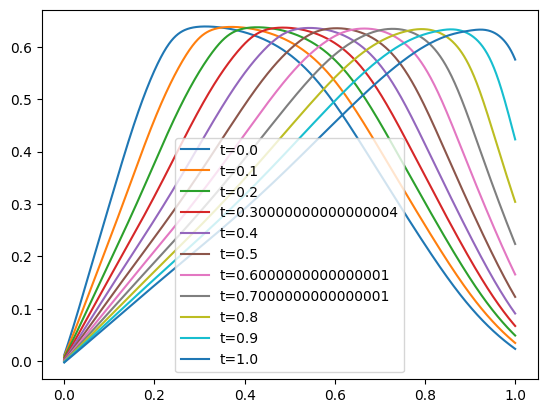

Epoch 21000/30000, loss: 0.03
time elapsed: 220.0196032524109


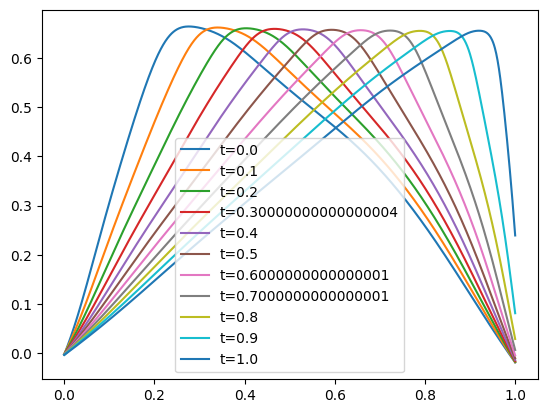

Epoch 24000/30000, loss: 0.03
time elapsed: 249.39027786254883


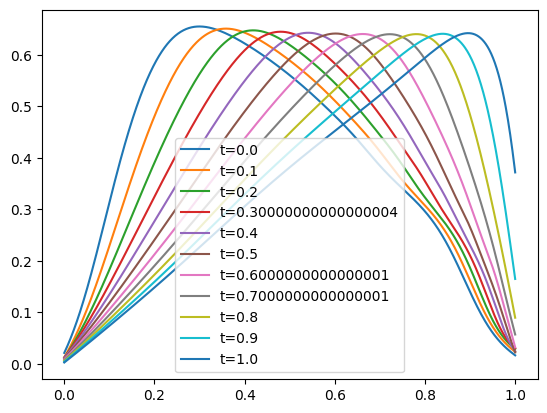

Epoch 27000/30000, loss: 0.03
time elapsed: 279.26984095573425


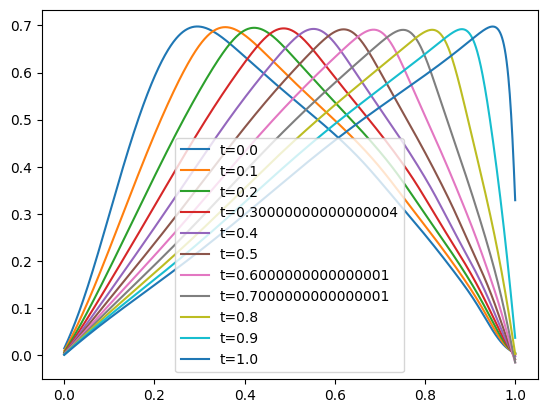

()

In [ ]:
#increading learning rate to 5e-4, and also creating the bdary pts inside the training function inside the model. Also will create new random 2N collocation pts at each epoch
samplemodel=YWTry(2,1, epochs=30000, lr=5e-4).to(DEVICE)
samplemodel.Train(inputs, Outputs)

Epoch 0/45000, loss: 0.14
time elapsed: 0.013748407363891602


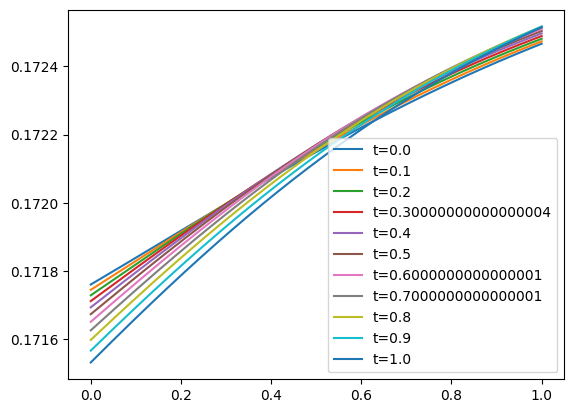

Epoch 4500/45000, loss: 0.05
time elapsed: 42.73314070701599


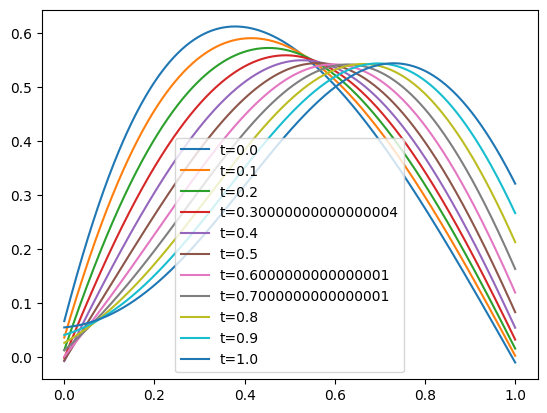

Epoch 9000/45000, loss: 0.05
time elapsed: 84.61953520774841


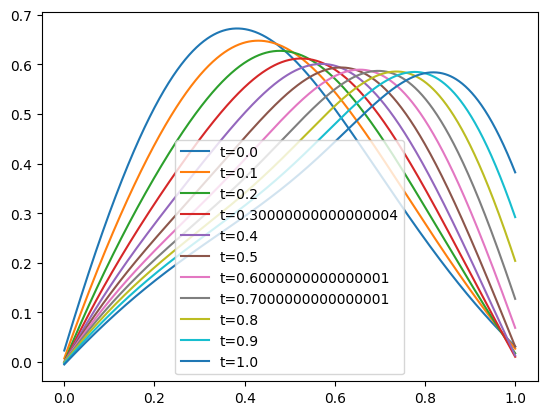

Epoch 13500/45000, loss: 0.05
time elapsed: 127.01210331916809


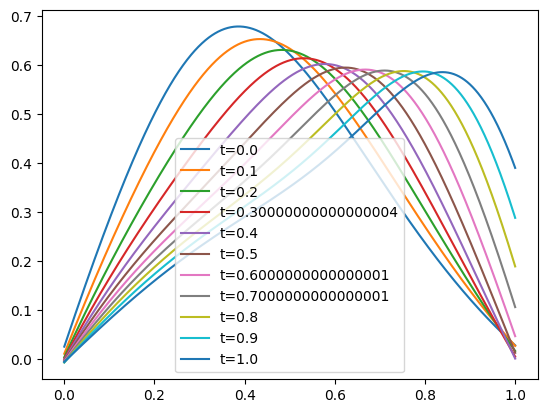

Epoch 18000/45000, loss: 0.04
time elapsed: 170.09623408317566


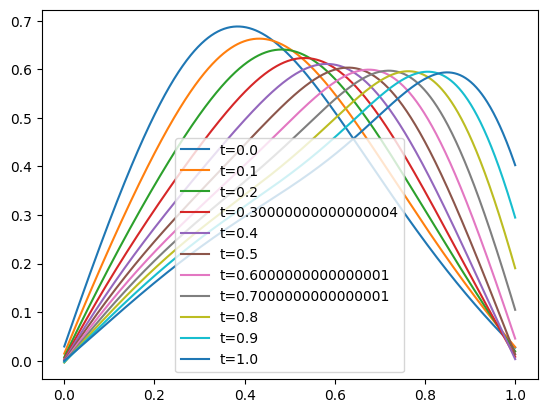

Epoch 22500/45000, loss: 0.04
time elapsed: 211.37706899642944


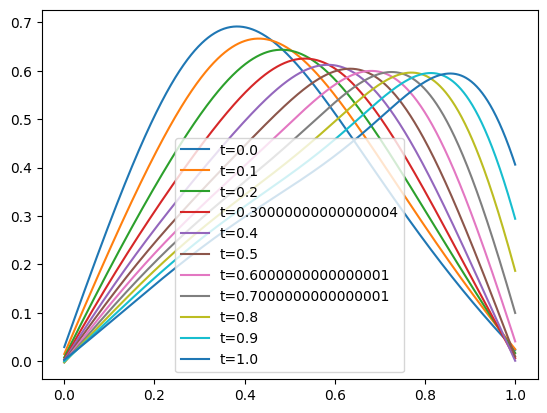

Epoch 27000/45000, loss: 0.04
time elapsed: 252.74105429649353


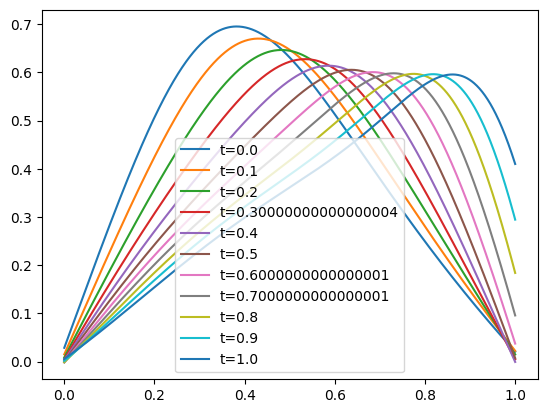

Epoch 31500/45000, loss: 0.04
time elapsed: 299.46512031555176


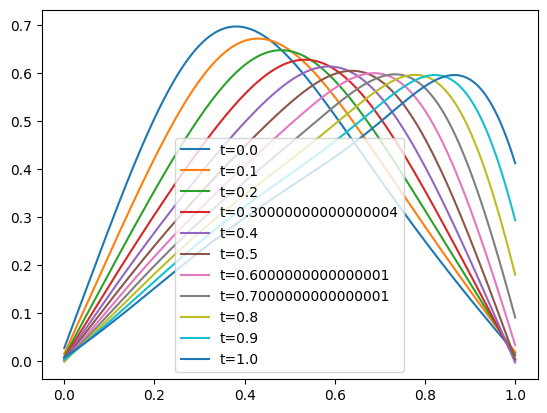

Epoch 36000/45000, loss: 0.04
time elapsed: 341.5437397956848


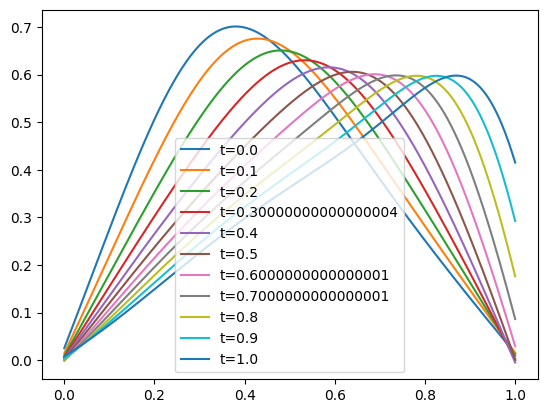

KeyboardInterrupt: 

In [ ]:
#doesn't work? I'm taking away the re-doing cpts bc it takes too long. Also changing the lr to smaller again
samplemodel=YWTry(2,1, epochs=45000, lr=5e-5).to(DEVICE)
samplemodel.Train(inputs, Outputs)

Epoch 0/45000, loss: 0.04
time elapsed: 0.04283618927001953


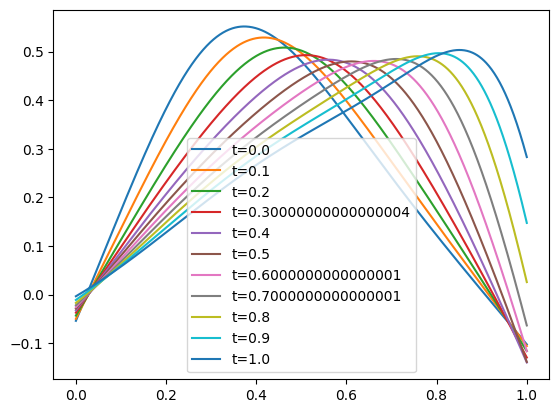

Epoch 4500/45000, loss: 0.04
time elapsed: 41.65462374687195


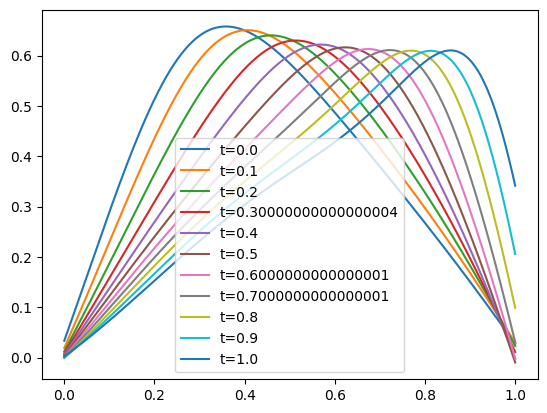

Epoch 9000/45000, loss: 0.04
time elapsed: 83.22682547569275


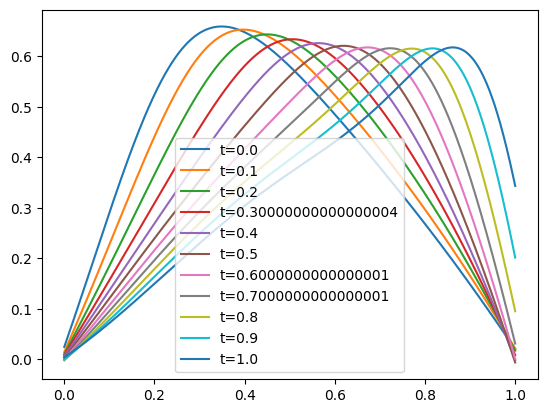

Epoch 13500/45000, loss: 0.04
time elapsed: 125.83913016319275


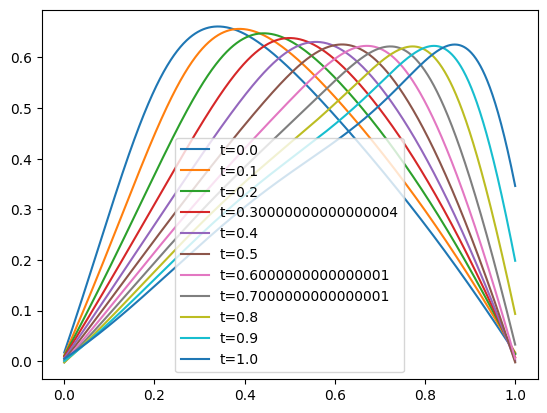

Epoch 18000/45000, loss: 0.04
time elapsed: 166.7399926185608


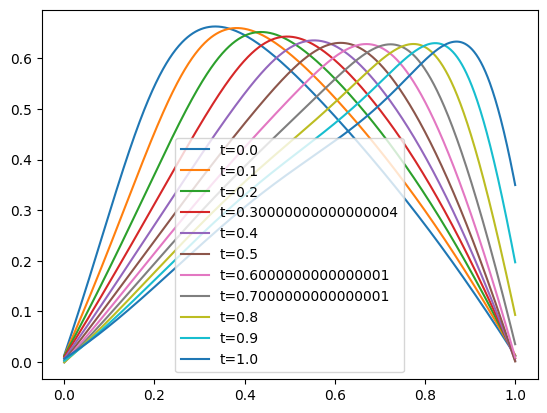

Epoch 22500/45000, loss: 0.04
time elapsed: 207.73150753974915


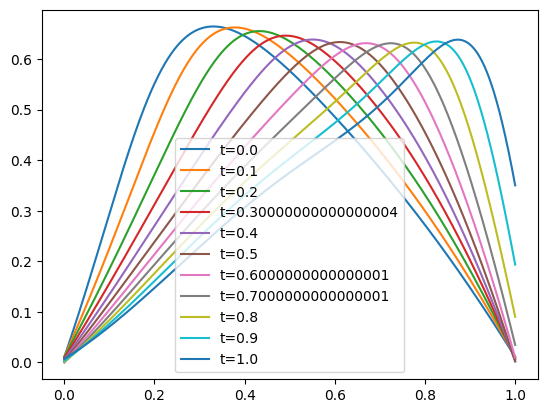

Epoch 27000/45000, loss: 0.04
time elapsed: 248.68550539016724


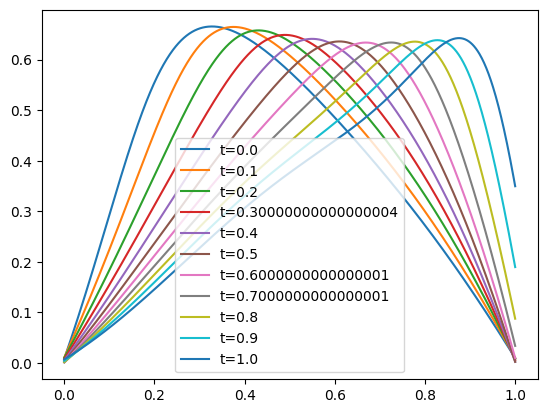

Epoch 31500/45000, loss: 0.04
time elapsed: 290.43958926200867


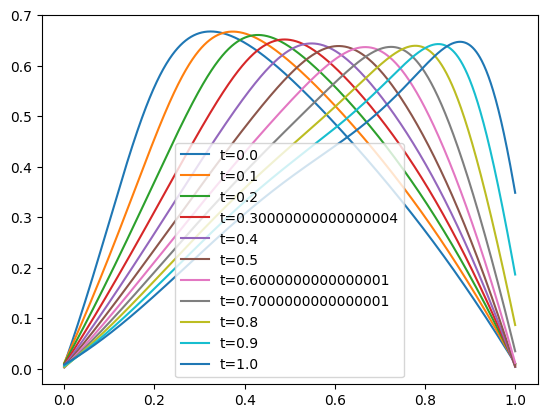

Epoch 36000/45000, loss: 0.04
time elapsed: 332.07360768318176


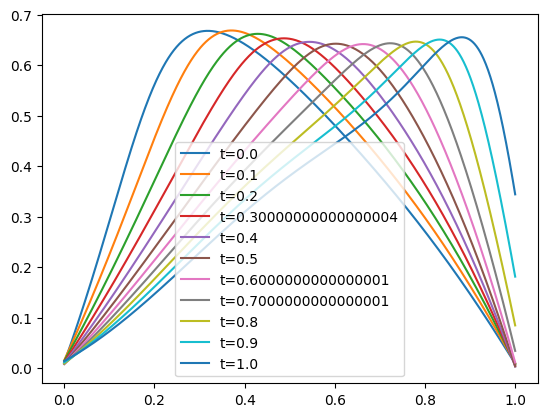

Epoch 40500/45000, loss: 0.04
time elapsed: 372.85303258895874


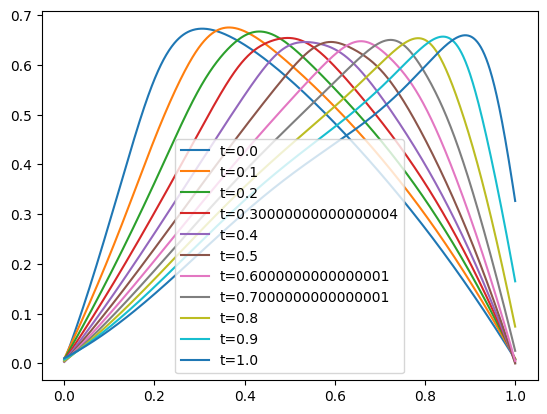

KeyboardInterrupt: 

In [ ]:
samplemodel.Train(inputs, Outputs) #another inputs outputs

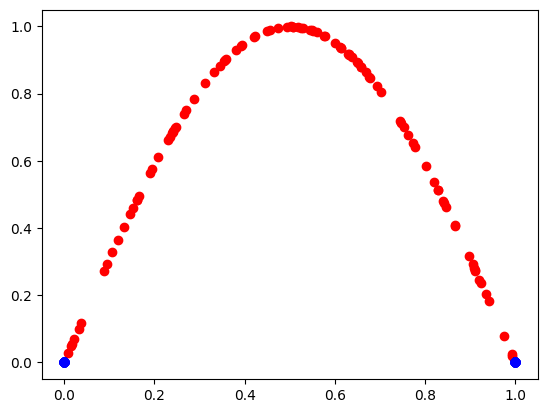

In [ ]:
plt.plot(inputinit[:,0], outputinit,'ro')
plt.plot(inputboundary[:,0], outputboundary,'bo')

In [ ]:
samplemodel.Model(torch.tensor([.5,0]))

tensor([0.2235], grad_fn=<ViewBackward0>)

In [ ]:
#Siyong explanation of the error (06302024) - loss function was taking outer product of input (N vector) and output (N x 1 tensor) and averaging over them.

samplemodel=YWTry(2,1, epochs=30000, lr=5e-5).to(DEVICE)
samplemodel.Model(cpts).shape
samplemodel.Model(cpts)[:,0]

torch.set_default_dtype(default_dtype)
a=torch.tensor([[1],[2]])
a
b=torch.tensor([1,1])
b.shape
c=a-b-1
c.float().mean()

tensor(-0.5000, dtype=torch.float32)

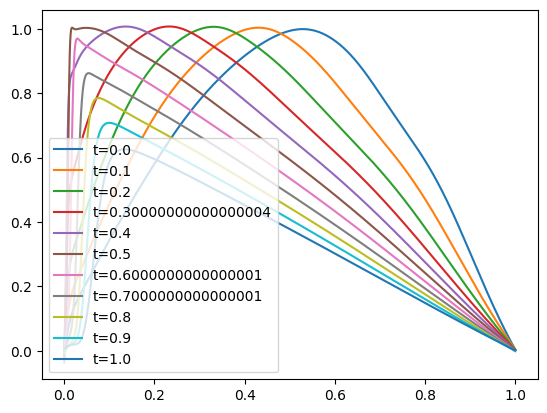

In [ ]:
import matplotlib.pyplot as plt
t=np.linspace(0,1,11)
for timestamp in t:
  xn=np.linspace(0,1,1000)
  x=torch.tensor(xn, dtype=default_dtype)
  coord=torch.column_stack((x,torch.full(x.shape, timestamp))) #https://pytorch.org/docs/stable/generated/torch.full.html
  Uout=samplemodel.Model(coord).detach().numpy()
  plt.plot(xn,Uout, label='t={}'.format(timestamp))
  plt.legend()


In [ ]:
#figuring out grad

#https://pytorch.org/docs/stable/generated/torch.autograd.grad.html
#autograd only takes against scalar products
x=torch.tensor([1,2,3], dtype=float, requires_grad=True)
y=torch.tensor([1,1,1], dtype=float, requires_grad=True)
z=torch.zeros(3)
z[0]=x[0]+x[2]
z[1]=x[1]*2
z[2]=x[2]*3


# z=2*x+y
#z.backward()
Z0_x= torch.autograd.grad(z.sum(),x)[0]
print(Z0_x)
type(Z0_x)

#2024.06.24 siyong changes on the copy doc
def func(x):
  z = torch.zeros(3)
  z[0] = x[0]+x[2]
  z[1] = x[1]*2
  z[2] = x[2]*3
  return z
# https://pytorch.org/docs/stable/generated/torch.autograd.functional.jacobian.html
Z0_x = torch.autograd.functional.jacobian(func, x, create_graph=False, strict=False, vectorize=False, strategy='reverse-mode')[:,2]
print(Z0_x)
type(Z0_x)


print(z)
print(z*x)

tensor([1., 2., 4.])
tensor([1., 0., 3.])
tensor([4., 4., 9.], grad_fn=<CopySlices>)
tensor([ 4.,  8., 27.], grad_fn=<MulBackward0>)


///divider

try1:
epoch30000, lr1e-5,optimizer=adam,
Epoch 0/30000, loss: 0.39
Epoch 3000/30000, loss: 0.32
Epoch 6000/30000, loss: 0.27
Epoch 9000/30000, loss: 0.23
Epoch 12000/30000, loss: 0.19
Epoch 15000/30000, loss: 0.16
Epoch 18000/30000, loss: 0.14
Epoch 21000/30000, loss: 0.13
Epoch 24000/30000, loss: 0.13
Epoch 27000/30000, loss: 0.13


try2: epoch30000, lr1e-4,optimizer=adam,
Epoch 0/30000, loss: 0.20
Epoch 3000/30000, loss: 0.12
Epoch 6000/30000, loss: 0.12
Epoch 9000/30000, loss: 0.12
Epoch 12000/30000, loss: 0.12
Epoch 15000/30000, loss: 0.12
Epoch 18000/30000, loss: 0.12
Epoch 21000/30000, loss: 0.12
Epoch 24000/30000, loss: 0.12
Epoch 27000/30000, loss: 0.12


try3: same as above (but i added time stamps)
usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([300, 1])) that is different to the input size (torch.Size([300])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0/30000, loss: 0.84
time elapsed: 0.008864164352416992
Epoch 3000/30000, loss: 0.14
time elapsed: 12.571324110031128
Epoch 6000/30000, loss: 0.13
time elapsed: 23.610451221466064
Epoch 9000/30000, loss: 0.13
time elapsed: 34.72315692901611
Epoch 12000/30000, loss: 0.13
time elapsed: 45.22088980674744
Epoch 15000/30000, loss: 0.13
time elapsed: 56.28272533416748
Epoch 18000/30000, loss: 0.13
time elapsed: 67.95624613761902
Epoch 21000/30000, loss: 0.13
time elapsed: 79.10966062545776
Epoch 24000/30000, loss: 0.13
time elapsed: 90.2882821559906
Epoch 27000/30000, loss: 0.13
time elapsed: 101.59162855148315
()



try4 and 5: I added the loss_g b/c I was getting the user warning for the array sizes

Also lr=5e-5

Tweaked the physics loss to correctly compute Ut and Ux at any given input. For try 4 I tried to average over all the collocation pts, but WHY DOESN'T GRAD CALCULATE JACOBIAN AS A MULTIDIMERSIONAL TENSOR??. It only lets me compute the gradient at ONE COLOCATION POINT at one time. So then I had to sample it at random colocation points.

Epoch 0/30000, loss: 0.20
time elapsed: 0.009164810180664062
Epoch 3000/30000, loss: 0.11
time elapsed: 11.652799844741821
Epoch 6000/30000, loss: 0.11
time elapsed: 22.364651203155518
Epoch 9000/30000, loss: 0.11
time elapsed: 33.31175208091736
Epoch 12000/30000, loss: 0.11
time elapsed: 44.25128674507141
Epoch 15000/30000, loss: 0.11
time elapsed: 55.18576502799988
Epoch 18000/30000, loss: 0.11
time elapsed: 65.6930046081543
Epoch 21000/30000, loss: 0.11
time elapsed: 77.58977150917053
Epoch 24000/30000, loss: 0.11
time elapsed: 88.72513246536255
Epoch 27000/30000, loss: 0.11
time elapsed: 99.91305303573608

In [ ]:
A=torch. ones(3)
A.shape

AA=torch.cat((A,A,A))
print(AA)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
#define losses (not necessary?)
#MS loss on boundary conditions: from princeton tutorial
def loss_g(t_p, t_c):
 squared_diffs = (t_p - t_c)**2
 return squared_diffs.mean()

#physics loss
def loss_f(inputs): #model is the neural network. I need to figure out the syntax
#should put cpts, the colocation pts, as the input
  nnpred=Model(inputs)
  Ut=grad(nnpred, inputs[:,1]) #grad against the time component, all rows, 2nd column
  Ux=grad(nnpred, inputs[:,1])
  eq = (Ut-nnpred*Ux)**2
  return eq.mean()

#theowolf code
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT

    return torch.mean(pde**2)

In [ ]:
class YWModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


In [ ]:
def grad(outputs, inputs):
    """Computes the partial derivative of
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

input = Variable(torch.tensor(np.array([np.linspace(0, 1000, 1000),np.linspace(0, 10, 1000)])), requires_grad=True)
grad((lambda x: x**2)(input), input)

(tensor([[0.0000e+00, 2.0020e+00, 4.0040e+00,  ..., 1.9960e+03, 1.9980e+03,
          2.0000e+03],
         [0.0000e+00, 2.0020e-02, 4.0040e-02,  ..., 1.9960e+01, 1.9980e+01,
          2.0000e+01]], dtype=torch.float64, grad_fn=<MulBackward0>),)

In [ ]:
from torch.autograd import Variable

input = Variable(torch.linspace(0, 1000, steps=1000), requires_grad=True)
torch.autograd.grad((lambda x: x**2)(input), input, grad_outputs=torch.ones_like(input), create_graph=True)

(tensor([   0.0000,    2.0020,    4.0040,    6.0060,    8.0080,   10.0100,
           12.0120,   14.0140,   16.0160,   18.0180,   20.0200,   22.0220,
           24.0240,   26.0260,   28.0280,   30.0300,   32.0320,   34.0340,
           36.0360,   38.0380,   40.0400,   42.0420,   44.0440,   46.0460,
           48.0480,   50.0500,   52.0521,   54.0541,   56.0561,   58.0581,
           60.0601,   62.0621,   64.0641,   66.0661,   68.0681,   70.0701,
           72.0721,   74.0741,   76.0761,   78.0781,   80.0801,   82.0821,
           84.0841,   86.0861,   88.0881,   90.0901,   92.0921,   94.0941,
           96.0961,   98.0981,  100.1001,  102.1021,  104.1041,  106.1061,
          108.1081,  110.1101,  112.1121,  114.1141,  116.1161,  118.1181,
          120.1201,  122.1221,  124.1241,  126.1261,  128.1281,  130.1301,
          132.1321,  134.1341,  136.1361,  138.1381,  140.1401,  142.1421,
          144.1441,  146.1461,  148.1481,  150.1501,  152.1521,  154.1542,
          156.1562,  158.